In [1]:
from sklearn.metrics import silhouette_score
from itertools import combinations
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import StratifiedShuffleSplit
import pandas as pd
from utils import get_dfs
(full_df, float_df, holdout) = get_dfs()
full_df.columns

/Users/emilvinther/ITU/3_semester/data mining/DataMining/utils.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['track_album_release_date'] = pd.to_datetime(
/Users/emilvinther/ITU/3_semester/data mining/DataMining/utils.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['year'] = df['track_album_release_date'].dt.year


Index(['track_id', 'track_name', 'track_artist', 'track_popularity',
       'track_album_id', 'track_album_name', 'playlist_name', 'playlist_id',
       'playlist_genre', 'playlist_subgenre', 'danceability', 'energy', 'key',
       'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'duration_ms', 'year'],
      dtype='object')

In [2]:
# data = pd.read_csv("spotify_songs.csv")

In [3]:
# First experiment:
# Setting range myself via dictionary by which I determine mood

# selecting relevant columns
columns = ["track_name", "energy", "valence", "danceability"]

# new datafram with selected columns
data = full_df.loc[:, columns]
data

,track_name,energy,valence,danceability
8150,Danza Kuduro - Radio Edit,0.899,0.887,0.699
23549,Single Ladies (Put a Ring On It),0.606,0.502,0.727
6800,Verano del 2006,0.631,0.578,0.698
15997,Doctor Doctor,0.799,0.561,0.298
17913,El Problemon,0.776,0.809,0.780
...,...,...,...,...
24677,Get It On Tonite,0.526,0.858,0.811
5769,Gandhi Money,0.674,0.788,0.807
860,Victory (Remix),0.592,0.348,0.589
17258,From Me To You - Radio Edit,0.956,0.596,0.633


In [4]:
# in this mood dict i tried to assign distinct values to each attribute/mood. however, ~19000 tuples were assigned with undefined mood
distinct_moods = {
    'energy boost': {'valence': (0.9, 1.0), 'energy': (0.9, 1.0)},
    'i am happy': {'valence': (0.6, 0.8), 'energy': (0.6, 0.8)},
    'just give me a loving background soundscape': {'valence': (0.5, 0.5), 'energy': (0.5, 0.5)},
    'i am sad and a bit depressed': {'valence': (0.0, 0.4), 'energy': (0.0, 0.4)}
}

# with this mood dict i tried to overlap some ranges. however, this will lead to low distinction between clusters.
# it resulted in ~15500 tuples assigned to undefined mood
overlapping_moods = {
    'energy boost': {'valence': (0.8, 1.0), 'energy': (0.8, 1.0)},
    'i am happy': {'valence': (0.5, 0.8), 'energy': (0.5, 0.8)},
    'just give me a loving background soundscape': {'valence': (0.3, 0.5), 'energy': (0.3, 0.5)},
    'i am sad and a bit depressed': {'valence': (0.0, 0.3), 'energy': (0.0, 0.3)}
}

In [5]:
def assign_mood_label(entry):
    for mood, ranges in distinct_moods.items():
        if all(ranges[feature][0] <= entry[feature] <= ranges[feature][1] for feature in ['valence', 'energy']):
            print(f"Assigned '{mood}' to entry {entry.name}")
            return mood
    print(
        f"Assigned 'undefined mood' to entry {entry.name}: valence={entry['valence']}, energy={entry['energy']}")
    return 'undefined mood'

In [6]:
def assign_mood_label(entry):
    for mood, ranges in overlapping_moods.items():
        if all(ranges[feature][0] <= entry[feature] <= ranges[feature][1] for feature in ['valence', 'energy']):
            print(f"Assigned '{mood}' to entry {entry.name}")
            return mood
    print(
        f"Assigned 'undefined mood' to entry {entry.name}: valence={entry['valence']}, energy={entry['energy']}")
    return 'undefined mood'

In [7]:
data['mood_label'] = data.apply(assign_mood_label, axis=1)

Assigned 'energy boost' to entry 8150
Assigned 'i am happy' to entry 23549
Assigned 'i am happy' to entry 6800
Assigned 'i am happy' to entry 15997
Assigned 'undefined mood' to entry 17913: valence=0.809, energy=0.776
Assigned 'undefined mood' to entry 22176: valence=0.247, energy=0.412
Assigned 'i am happy' to entry 8881
Assigned 'undefined mood' to entry 10871: valence=0.208, energy=0.529
Assigned 'undefined mood' to entry 32642: valence=0.193, energy=0.658
Assigned 'i am happy' to entry 19367
Assigned 'undefined mood' to entry 31229: valence=0.304, energy=0.812
Assigned 'undefined mood' to entry 27856: valence=0.241, energy=0.895
Assigned 'undefined mood' to entry 2174: valence=0.863, energy=0.503
Assigned 'undefined mood' to entry 6756: valence=0.752, energy=0.879
Assigned 'undefined mood' to entry 20671: valence=0.244, energy=0.545
Assigned 'undefined mood' to entry 27327: valence=0.719, energy=0.859
Assigned 'i am happy' to entry 11920
Assigned 'undefined mood' to entry 2333: val

In [8]:
# checking the distribution of moods
data['mood_label'].value_counts()

# First experiment conclusion:
# Defining clusters myself didn't work since too many tuples falls outside of the range of moods I defined.
# Furthermore, it does not really qualify as a unsupervised method, as it inherently label the tuples based on hard coding the moods.

mood_label
undefined mood                                 15485
i am happy                                      4845
energy boost                                    1195
just give me a loving background soundscape      870
i am sad and a bit depressed                     286
Name: count, dtype: int64

In [9]:
# Second experiment:
# Iterate a grid search look alike setup to find best combination of features
# that gives the highest possible silhouette score.
# Applying k-means


# read data again to start from scratch in experiment 2
data = pd.read_csv("spotify_songs.csv")

# features to combine
columns_float = ["energy", "valence", "danceability", "loudness", "tempo"]

# defining new df with the chosen features
df_float = data.loc[:, columns_float]

# defining what my features are
features = columns_float

# create combinations of features up until four units in the combination
all_possible_feature_combinations = list(combinations(features, 4))

# convert combinations to a list of tuples so that the iterator can run over the combinations
all_possible_feature_combinations = [
    tuple(combination) for combination in all_possible_feature_combinations]

# initialize variables to store the best feature combination and silhouette score
best_features = None
best_silhouette_score = -1

# standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_float)

# specify the range of clusters to consider. i specified the range to be between 2 and 10 clusters.
cluster_range = range(2, 10)

In [10]:
# iterate through the combinations (grid search)

# iterate over all possible feature combinations. the code was developed with help from chat gpt
for feature_combination in all_possible_feature_combinations:
    print(f"\nEvaluating Feature Combination: {feature_combination}")

    # Subsetting the DataFrame with selected features
    subset_data = df_float[list(feature_combination)].values

    # Iterate over different numbers of clusters
    for num_clusters in cluster_range:
        print(f"\n  Evaluating Number of Clusters: {num_clusters}")

        # Apply K-Means clustering
        kmeansModel = KMeans(n_clusters=num_clusters, random_state=42)
        labels = kmeansModel.fit_predict(subset_data)

        # Evaluate clustering quality using silhouette score
        silhouette_avg = silhouette_score(subset_data, labels)
        print(f"    Silhouette Score: {silhouette_avg}")

        # Update if a better combination is found
        if silhouette_avg > best_silhouette_score:
            best_silhouette_score = silhouette_avg
            best_features = feature_combination
            best_num_clusters = num_clusters

print("\nBest Feature Combination:", best_features)
print("Best Number of Clusters:", best_num_clusters)
print("Best Silhouette Score:", best_silhouette_score)

# Second experiment conclusion:
# The best feature combination is the four features 'energy', 'valence', 'danceability', and 'tempo'
# with a number of three clusters. It gives a score at 0.62. This is alright, however not great. Therefore we continue with investigating the clusters.


Evaluating Feature Combination: ('energy', 'valence', 'danceability', 'loudness')

  Evaluating Number of Clusters: 2


/Users/emilvinther/anaconda3/envs/dm/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


    Silhouette Score: 0.5863242291979328

  Evaluating Number of Clusters: 3


/Users/emilvinther/anaconda3/envs/dm/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


    Silhouette Score: 0.521558691089236

  Evaluating Number of Clusters: 4


/Users/emilvinther/anaconda3/envs/dm/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


    Silhouette Score: 0.48984865009948797

  Evaluating Number of Clusters: 5


/Users/emilvinther/anaconda3/envs/dm/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


    Silhouette Score: 0.4695653977213098

  Evaluating Number of Clusters: 6


/Users/emilvinther/anaconda3/envs/dm/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


    Silhouette Score: 0.4595403181479323

  Evaluating Number of Clusters: 7


/Users/emilvinther/anaconda3/envs/dm/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


    Silhouette Score: 0.44231294041846336

  Evaluating Number of Clusters: 8


/Users/emilvinther/anaconda3/envs/dm/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


    Silhouette Score: 0.43566077780656204

  Evaluating Number of Clusters: 9


/Users/emilvinther/anaconda3/envs/dm/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


    Silhouette Score: 0.4181834120194298

Evaluating Feature Combination: ('energy', 'valence', 'danceability', 'tempo')

  Evaluating Number of Clusters: 2


/Users/emilvinther/anaconda3/envs/dm/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


    Silhouette Score: 0.5573251511146803

  Evaluating Number of Clusters: 3


/Users/emilvinther/anaconda3/envs/dm/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


    Silhouette Score: 0.6239118086834944

  Evaluating Number of Clusters: 4


/Users/emilvinther/anaconda3/envs/dm/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


    Silhouette Score: 0.5994058064609323

  Evaluating Number of Clusters: 5


/Users/emilvinther/anaconda3/envs/dm/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


    Silhouette Score: 0.5759983499887963

  Evaluating Number of Clusters: 6


/Users/emilvinther/anaconda3/envs/dm/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


    Silhouette Score: 0.5746169774175386

  Evaluating Number of Clusters: 7


/Users/emilvinther/anaconda3/envs/dm/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


    Silhouette Score: 0.5693566222229223

  Evaluating Number of Clusters: 8


/Users/emilvinther/anaconda3/envs/dm/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


    Silhouette Score: 0.5686265320450129

  Evaluating Number of Clusters: 9


/Users/emilvinther/anaconda3/envs/dm/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


    Silhouette Score: 0.5659971239990258

Evaluating Feature Combination: ('energy', 'valence', 'loudness', 'tempo')

  Evaluating Number of Clusters: 2


/Users/emilvinther/anaconda3/envs/dm/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


    Silhouette Score: 0.5385835500846619

  Evaluating Number of Clusters: 3


/Users/emilvinther/anaconda3/envs/dm/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


    Silhouette Score: 0.5959749128206686

  Evaluating Number of Clusters: 4


/Users/emilvinther/anaconda3/envs/dm/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


    Silhouette Score: 0.5590961812240136

  Evaluating Number of Clusters: 5


/Users/emilvinther/anaconda3/envs/dm/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


    Silhouette Score: 0.521132782663543

  Evaluating Number of Clusters: 6


/Users/emilvinther/anaconda3/envs/dm/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


    Silhouette Score: 0.5044685728842105

  Evaluating Number of Clusters: 7


/Users/emilvinther/anaconda3/envs/dm/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


    Silhouette Score: 0.4903883385753876

  Evaluating Number of Clusters: 8


/Users/emilvinther/anaconda3/envs/dm/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


    Silhouette Score: 0.4847909891212755

  Evaluating Number of Clusters: 9


/Users/emilvinther/anaconda3/envs/dm/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


    Silhouette Score: 0.4588312848798407

Evaluating Feature Combination: ('energy', 'danceability', 'loudness', 'tempo')

  Evaluating Number of Clusters: 2


/Users/emilvinther/anaconda3/envs/dm/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


    Silhouette Score: 0.5386923289364111

  Evaluating Number of Clusters: 3


/Users/emilvinther/anaconda3/envs/dm/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


    Silhouette Score: 0.5961315778895737

  Evaluating Number of Clusters: 4


/Users/emilvinther/anaconda3/envs/dm/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


    Silhouette Score: 0.5593368860295925

  Evaluating Number of Clusters: 5


/Users/emilvinther/anaconda3/envs/dm/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


    Silhouette Score: 0.5226689833460053

  Evaluating Number of Clusters: 6


/Users/emilvinther/anaconda3/envs/dm/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


    Silhouette Score: 0.5048200744629695

  Evaluating Number of Clusters: 7


/Users/emilvinther/anaconda3/envs/dm/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


    Silhouette Score: 0.48414861180739216

  Evaluating Number of Clusters: 8


/Users/emilvinther/anaconda3/envs/dm/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


    Silhouette Score: 0.4838044411246369

  Evaluating Number of Clusters: 9


/Users/emilvinther/anaconda3/envs/dm/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


    Silhouette Score: 0.4592057065453207

Evaluating Feature Combination: ('valence', 'danceability', 'loudness', 'tempo')

  Evaluating Number of Clusters: 2


/Users/emilvinther/anaconda3/envs/dm/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


    Silhouette Score: 0.5386001041940534

  Evaluating Number of Clusters: 3


/Users/emilvinther/anaconda3/envs/dm/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


    Silhouette Score: 0.5959996448911806

  Evaluating Number of Clusters: 4


/Users/emilvinther/anaconda3/envs/dm/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


    Silhouette Score: 0.5591285704289897

  Evaluating Number of Clusters: 5


/Users/emilvinther/anaconda3/envs/dm/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


    Silhouette Score: 0.5224111598857556

  Evaluating Number of Clusters: 6


/Users/emilvinther/anaconda3/envs/dm/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


    Silhouette Score: 0.5045223699170613

  Evaluating Number of Clusters: 7


/Users/emilvinther/anaconda3/envs/dm/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


    Silhouette Score: 0.4904378054848543

  Evaluating Number of Clusters: 8


/Users/emilvinther/anaconda3/envs/dm/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


    Silhouette Score: 0.45215798649141026

  Evaluating Number of Clusters: 9


/Users/emilvinther/anaconda3/envs/dm/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


    Silhouette Score: 0.4597682010497752

Best Feature Combination: ('energy', 'valence', 'danceability', 'tempo')
Best Number of Clusters: 3
Best Silhouette Score: 0.6239118086834944


In [11]:
# After having found the best feature combination and clusters, I make a model based on these findings

#  after having found the best combo i read data and build df again to start from scratch
# data = pd.read_csv("spotify_songs.csv")
columns = ["energy", "valence", "danceability", "tempo"]
df_kmeans = full_df.loc[:, columns]
clusters = 3

# standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_kmeans)

In [12]:
# apply K-Means
kmeansModel = KMeans(n_clusters=clusters, random_state=42)
df_kmeans['cluster'] = kmeansModel.fit_predict(scaled_data)
# df_samples = StratifiedShuffleSplit(df_kmeans)
# sample = df_samples[0]
# sample
sample = df_kmeans.sample(2500)

/Users/emilvinther/anaconda3/envs/dm/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


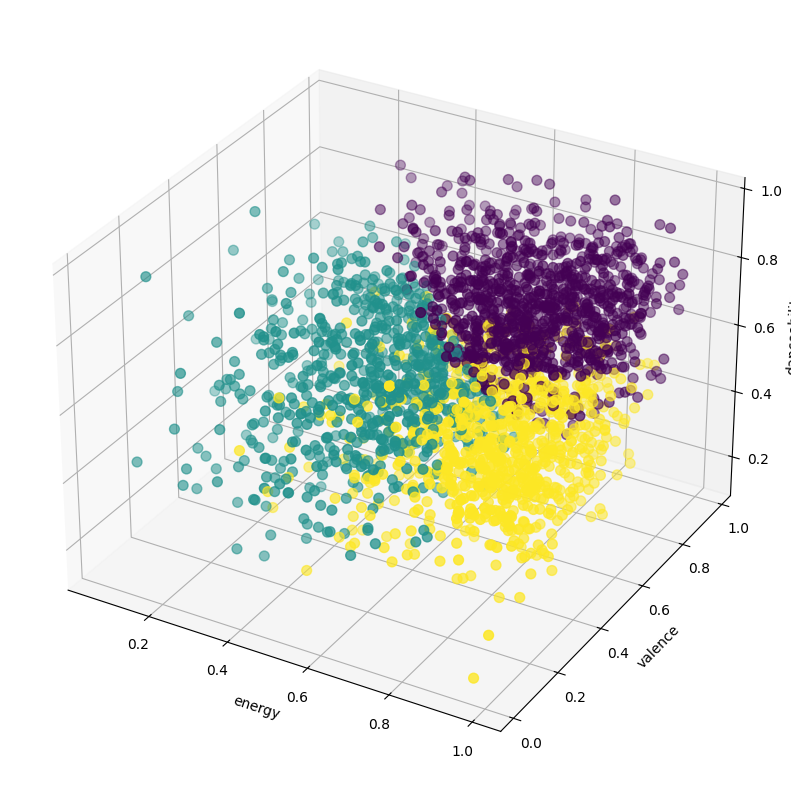

In [13]:
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(sample['energy'], sample['valence'], sample['danceability'],
           c=sample['cluster'], cmap='viridis', s=50)
# ax.scatter(kmeansModel.cluster_centers_[:, 0], kmeansModel.cluster_centers_[
#    :, 1], kmeansModel.cluster_centers_[:, 2], marker='x', s=200, linewidths=3, color='r')
ax.set_xlabel('energy')
ax.set_ylabel('valence')
ax.set_zlabel('danceability')
plt.show()

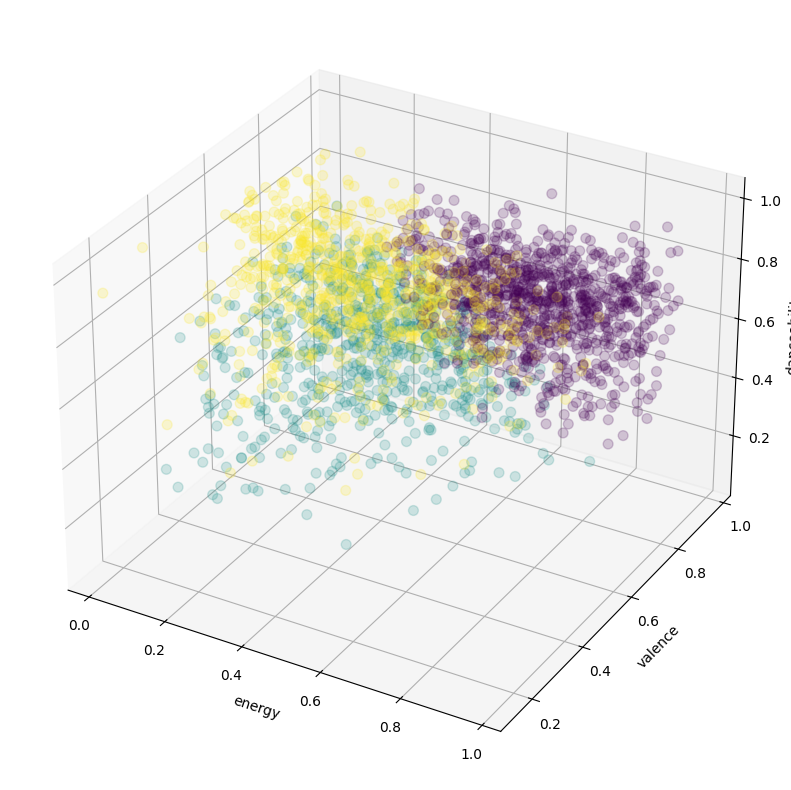

In [14]:
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(sample['valence'], sample['danceability'], sample['energy'],
           c=sample['cluster'], cmap='viridis', s=50, alpha=0.2)
# ax.scatter(kmeansModel.cluster_centers_[:, 0], kmeansModel.cluster_centers_[
#    :, 1], kmeansModel.cluster_centers_[:, 2], marker='x', s=200, linewidths=3, color='r')
ax.set_xlabel('energy')
ax.set_ylabel('valence')
ax.set_zlabel('danceability')
plt.show()
# Visualisation conclusion:
# By visualising the clusters as well as considering the silhouette score, the clustering
# is not really super great. there is not distinct seperation between the data points,
# and thereby not really any distinct clusters.

# Below i will explore a bit further with descriptive statistics

In [15]:
# using stats to look at the clusters
stats = df_kmeans.groupby("cluster").agg(['mean', 'median', 'std'])
print(stats)

# Below I explore a bit further plotting the cluster features and their mean score

           energy                    valence                  danceability  \
             mean median       std      mean median       std         mean   
cluster                                                                      
0        0.742202  0.753  0.129809  0.708770  0.714  0.148012     0.744616   
1        0.506081  0.518  0.151529  0.350861  0.346  0.163755     0.645592   
2        0.808266  0.832  0.130968  0.399050  0.389  0.190921     0.547278   

                               tempo                       
        median       std        mean    median        std  
cluster                                                    
0        0.748  0.094432  114.381451  113.9895  21.212131  
1        0.660  0.143046  107.958179  104.9705  23.292070  
2        0.559  0.123522  140.306507  131.0940  25.560380  


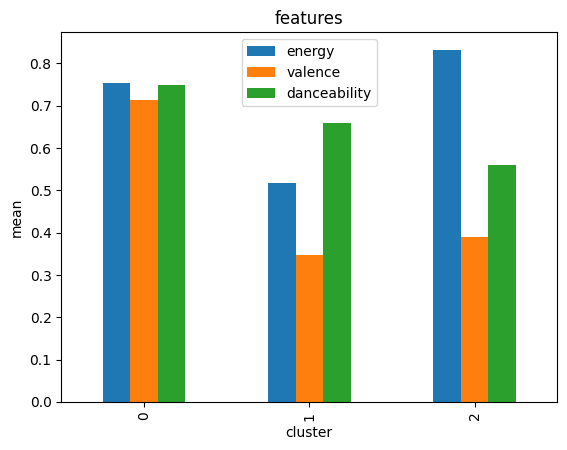

In [16]:
# plotting on some of the features
# dropping tempo since it skews the plot

columns = ["energy", "valence", "danceability", "cluster"]
energy_valence_danceability = df_kmeans.loc[:, columns]

cluster_means = energy_valence_danceability.groupby('cluster').median()
cluster_means.plot(kind='bar')
plt.title("features")
plt.ylabel("mean")
plt.show()

In [17]:
columns_to_join = data[['track_name', 'track_artist']]
joined_df = df_kmeans.join(columns_to_join)
joined_df

,energy,valence,danceability,tempo,cluster,track_name,track_artist
8150,0.899,0.887,0.699,130.102,0,Danza Kuduro - Radio Edit,Don Omar
23549,0.606,0.502,0.727,104.588,1,Single Ladies (Put a Ring On It),The Cleverlys
6800,0.631,0.578,0.698,83.084,0,Verano del 2006,Charles Ans
15997,0.799,0.561,0.298,143.072,2,Doctor Doctor,UFO
17913,0.776,0.809,0.780,122.600,0,El Problemon,Bonka
...,...,...,...,...,...,...,...
24677,0.526,0.858,0.811,99.001,0,Get It On Tonite,Montell Jordan
5769,0.674,0.788,0.807,94.984,0,Gandhi Money,DIVINE
860,0.592,0.348,0.589,141.131,2,Victory (Remix),Highlands Worship
17258,0.956,0.596,0.633,123.971,2,From Me To You - Radio Edit,Yolanda Be Cool


In [18]:
# building the recommender even though the clustering is not working greatly
# map real moods to cluster labels based on my interpretation of the clusters

cluster_rename = {
    0: 'i_need_an_energy_boost',
    1: 'i_feel_rhythmic',
    2: 'i_feel_happy_pop_and_dancy'
}

joined_df['cluster'] = joined_df['cluster'].replace(cluster_rename)

In [19]:
# build the method
columns_to_final_df = ["cluster", "track_name", "track_artist"]
final_df = joined_df.loc[:, columns_to_final_df]
final_df


def recommend_song(final_df, mood):
    filtered_df = final_df[final_df['cluster'] == mood]

    row = filtered_df.sample().iloc[0]
    song = row['track_name']
    artist = row['track_artist']
    return song, artist

In [20]:
# testing the method


# enter the mood here
mood = "i_need_an_energy_boost"

# call the method
song, artist = recommend_song(final_df, mood)
print(song, artist)

Behind Me Lil Bike


In [21]:
# Ideas for furhter studies:
# Write about the experiements, and expreess how feature engineering could have been performed such as:
# Create bins/Discreatization for popularity and tempo
# low-medium-high

# Combine features such as energy * loudness and then square it
# High score indicates high impact. Squaring it will emphasize the differences in the data.